Task 2. Setting up a RAG solution
In this first task, we will setup the Workbench environment, create a RAG solution from Alphabets 2022 financial annual report and perform some queries to the report. To store the embeddings we use Chroma, an open-source embeddings database that makes it straightforward to store embeddings.

In the first cell run the following command to install the Google Cloud Vertex AI SDKs. Either click the play play button at the top or enter SHIFT+ENTER on your keyboard to execute the cell.

In [1]:
!pip3 install --upgrade --user google-cloud-aiplatform umap-learn tqdm pypdf

Restart kernel after installs so that your environment can access the new packages.

In [3]:
import IPython
from IPython.display import Markdown, display
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

Initialize the environment variables for the current project.

In [1]:
PROJECT = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
LOCATION = "us-east1"

Import python display utilities and Google Cloud's Embeddings and Gemini models.

In [2]:
from vertexai.preview.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel
text_embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
model = GenerativeModel('gemini-pro')

Download Alphabet's financial annual report for 2022 so that we can query it.

In [3]:
import urllib.request

# download alphabet's annual pdf report
url = "https://abc.xyz/assets/d4/4f/a48b94d548d0b2fdc029a95e8c63"
file = "2022-alphabet-annual-report.pdf"

urllib.request.urlretrieve(f"{url}/{file}", filename=f"{file}")

('2022-alphabet-annual-report.pdf',
 <http.client.HTTPMessage at 0x7fec941e7ee0>)

Convert the PDF into text.

In [4]:
!pip install PyPDF2
import PyPDF2

# Open the PDF file in binary mode
with open('2022-alphabet-annual-report.pdf', 'rb') as file:
    # Create a PdfFileReader object
    pdf_reader = PyPDF2.PdfReader(file)
    pdf_texts = [p.extract_text().strip() for p in pdf_reader.pages]

    # Filter the empty strings
    pdf_texts = [text for text in pdf_texts if text]

    print(pdf_texts[0])

To our investors,
2022 was a year full of change and uncertainty around 
the world. In February, when war broke out in Ukraine, our teams worked around-the-clock to make sure our products were helpful to people who needed them, from providing trustworthy information on Search to disrupting cyberattacks to partnering with the government to deploy air raid alerts. In March, I traveled to Warsaw, Poland, where I met Googlers hosting families who sought refuge, talked with entrepreneurs using our office spaces, and saw how our products like Google Translate were helping Ukrainians find a bit of hope and connection.
By late spring, the tech industry was adjusting to a 
more challenging macroeconomic environment, and as a company we embarked on efforts to sharpen our focus and make sure our efforts are aligned with our highest priorities. Near the end of the year, AI reached an inflection point, made possible by our foundational breakthroughs like Transformer and advances in diffusion models

Split the PDF into chunks so that we can create embedding out of them. The embedding's APIs and the LLM have token limits, that's why we need to split the text into smaller units as opposed to sending the whole text.

In [5]:
!pip install langchain sentence-transformers
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=0
)
character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

print(character_split_texts[10])
print(f"\nTotal chunks: {len(character_split_texts)}")

5
Year in Review 2022
Multisearch
With multisearch, people can now 
search with both images and text  
at the same time in Google Lens.

Total chunks: 489


Create more chunks if the size of the existing chunk is too big. In this case, we define too big as 256 tokens.

In [6]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

5 year in review 2022 multisearch with multisearch, people can now search with both images and text at the same time in google lens.

Total chunks: 511


Install and initialize the embeddings database with an embeddings function.

In [7]:
!pip3 install chromadb==0.5.3
!pip3 install google-generativeai
import chromadb
import os
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
# import chromadb.utils.embedding_functions as embedding_functions

# import getpass
# import os

# getpass will prompt for an API Key
# The API Key is needed for Chroma DB
# API_KEY = getpass.getpass("Provide your Google API Key")

# embedding_function = embedding_functions.GooglePalmEmbeddingFunction(api_key=creds.token)

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[[-0.03299040347337723, -0.03994394838809967, 0.02768322080373764, -0.020394684746861458, 0.010316920466721058, -0.013435319997370243, -0.11188780516386032, 0.0020084811840206385, -0.008219876326620579, -0.054634515196084976, 0.05009115859866142, 0.060834359377622604, 0.050288472324609756, 0.04027774557471275, 0.0002621527237351984, -0.01453626248985529, -0.054342564195394516, 0.0022568206768482924, -0.03845825418829918, -0.053221721202135086, 0.0584506019949913, -0.04633062705397606, 0.11275571584701538, -0.0909026712179184, -0.005574648734182119, 0.02450973354279995, -0.14071720838546753, -0.09735380113124847, -0.0076984865590929985, 0.018437139689922333, -5.31673249497544e-05, 0.0346691757440567, -0.006346573121845722, 0.11858687549829483, -0.0844186320900917, 0.0539005771279335, -0.06958915293216705, 0.0504479855298996, -0.010030870325863361, 0.016402777284383774, -0.042457979172468185, -0.036958418786525726, -0.03685655817389488, -0.059337131679058075, 0.03196948766708374, 0.02155

Create embedings and store them in the chroma database.

In [8]:
import numpy as np
print(np.__version__)


1.26.4


In [9]:
chroma_client = chromadb.Client()
print("collection")
chroma_collection = chroma_client.create_collection("alphabet_annual_report_2022", embedding_function=embedding_function)
print("created")
ids = [str(i) for i in range(len(token_split_texts))]
print("adding")
chroma_collection.add(ids=ids, documents=token_split_texts)
chroma_collection.count()

collection
created
adding


511

Ask a questions to perform an embeddings search on the chroma db database.

In [10]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

accrued revenue share 1, 639 1, 682 ( 445 ) deferred revenue 635 774 367


for additional details, including a reconciliation of the u. s. federal statutory rate to our effective tax rate, see note 14 of the notes to consolidated financial statements included in item 8 of this annual report on form 10 - k. executive overview the following table summarizes our consolidated financial results ( in millions, except for per share information and percentages ) : year ended december 31, 2021 2022 $ change % change consolidated revenues $ 257, 637 $ 282, 836 $ 25, 199 10 % change in consolidated constant currency revenues ( 1 ) 14 % cost of revenues $ 110, 939 $ 126, 203 $ 15, 264 14 % operating expenses $ 67, 984 $ 81, 791 $ 13, 807 20 % operating income $ 78, 714 $ 74, 842 $ ( 3, 872 ) ( 5 ) % operating margin 31 % 26 % ( 5 ) % other income ( expense ), net $ 12, 020 $ ( 3, 514 ) $ ( 15, 534 ) ( 129 ) % net income $ 76, 033 $ 59, 972 $ ( 16, 061 ) ( 21 ) % diluted eps $ 5. 61 $ 4. 56 $ ( 1. 

Use a RAG to answer the question given the information that was looked up from the database.

In [12]:
def rag(query, retrieved_documents, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about information contained in an annual report.\n'
    f'You will be shown the user\'s question, and the relevant information from the annual report.\n'
    f'Answer the user\'s question using only this information.\n\n'
    f'Question: {query}. \n Information: {information}')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

response = rag(query=query, retrieved_documents=retrieved_documents, model=model)
print(response)

NotFound: 404 Publisher Model `projects/qwiklabs-gcp-01-5d9ec7df43cf/locations/us-central1/publishers/google/models/gemini-pro` was not found or your project does not have access to it. Please ensure you are using a valid model version. For more information, see: https://cloud.google.com/vertex-ai/generative-ai/docs/learn/model-versions

Task 3. Explore embeddings distribution with user queries

In this task, we use the python library umap to reduce the dimensions of our embeddings to two dimensions, so that we can see how close they are represented in a graph. Then we try different queries to see how different queries relate to the existing embedding space. This can give us an intuition about whether the answer might be found in the embeddings space.

Transform embeddigns into a two-dimensional space.

In [13]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
  0%|          | 0/511 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 1/511 [00:05<43:02,  5.06s/it]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and

Plot the two-dimensional embeddings.

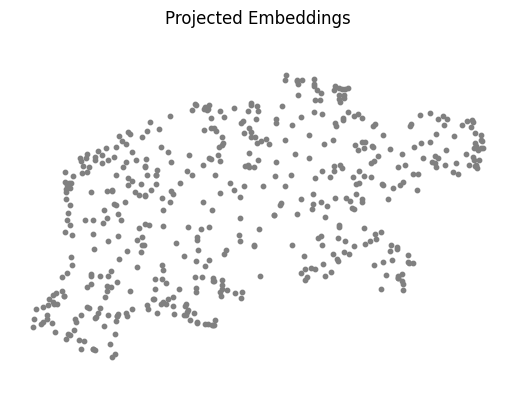

In [14]:
import matplotlib.pyplot as plt

def plot(title='Projected Embeddings', projected_dataset_embeddings=[], projected_query_embedding=[], projected_retrieved_embeddings=[]):
    # Plot the projected query and retrieved documents in the embedding space
    plt.figure()
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
    if len(projected_query_embedding) > 0:
        plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
    if len(projected_retrieved_embeddings) > 0:
        plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{title}')
    plt.axis('off')

plot(projected_dataset_embeddings=projected_dataset_embeddings)

Ask the same question to the database again, but this time retrieve the embeddings in addition to the documents.

In [15]:
query = "What was the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

accrued revenue share 1, 639 1, 682 ( 445 ) deferred revenue 635 774 367

for additional details, including a reconciliation of the u. s. federal statutory rate to our effective tax rate, see note 14 of the notes to consolidated financial statements included in item 8 of this annual report on form 10 - k. executive overview the following table summarizes our consolidated financial results ( in millions, except for per share information and percentages ) : year ended december 31, 2021 2022 $ change % change consolidated revenues $ 257, 637 $ 282, 836 $ 25, 199 10 % change in consolidated constant currency revenues ( 1 ) 14 % cost of revenues $ 110, 939 $ 126, 203 $ 15, 264 14 % operating expenses $ 67, 984 $ 81, 791 $ 13, 807 20 % operating income $ 78, 714 $ 74, 842 $ ( 3, 872 ) ( 5 ) % operating margin 31 % 26 % ( 5 ) % other income ( expense ), net $ 12, 020 $ ( 3, 514 ) $ ( 15, 534 ) ( 129 ) % net income $ 76, 033 $ 59, 972 $ ( 16, 061 ) ( 21 ) % diluted eps $ 5. 61 $ 4. 56 $ ( 1. 0

Embed the question and answer and transform it into two dimentions.

In [16]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

Plot the projected query and retrieved documents in the embedding space.

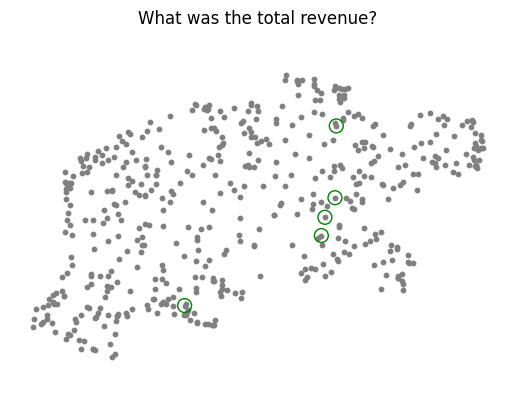

In [17]:
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Let's try again with a different question to see another example.

In [18]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

to irrelevance over time, especially in technology, where change tends to be revolutionary, not evolutionary. people thought we were crazy when we acquired youtube and android and when we launched chrome, but those efforts have matured into major platforms for digital video and mobile devices and a safer, popular browser. we continue to look toward the future and to invest for the long term within each of our segments. as we said in the original founders ’ letter, we will not shy away from high - risk, high - reward projects that we believe in, as they are the key to our long - term success. the power of ai we believe that ai is a foundational and transformational technology that will provide compelling and helpful benefits to people and society through its capacity to assist, complement, empower, and inspire people in almost every field of human endeavor. as

are making across our businesses, such as in ai, reflect our ongoing efforts to innovate and provide products and services that

Create embeddings and projections.

In [19]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

Plot the projected query and retrieved documents in the embedding space. Notice how close results are, since the answer seems to be contained in the database.

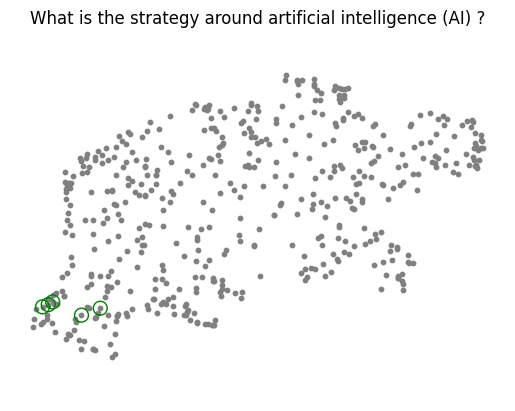

In [20]:
plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Let's do all these again with another question that might be contained in the dataset to see that results are still close to one another.

our operating results have fluctuated, and may in the future fluctuate, as a result of a number of factors, many outside of our control, including the cyclicality and seasonality in our business and geopolitical events. as a result, comparing our operating results ( including our expenses as a percentage of our revenues ) on a period - to - period basis may not be meaningful, and our past results should not be relied on as an indication of our future performance. consequently, our operating results in future quarters may fall below expectations. acquisitions, joint ventures, investments, and divestitures could result in operating difficulties, dilution, and other consequences that could harm our business, financial condition, and operating results. acquisitions, joint ventures, investments, and divestitures are important elements of our overall corporate strategy and use of capital,

customer contracts with commitments for performance obligations, including our estimate of the remainin

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 

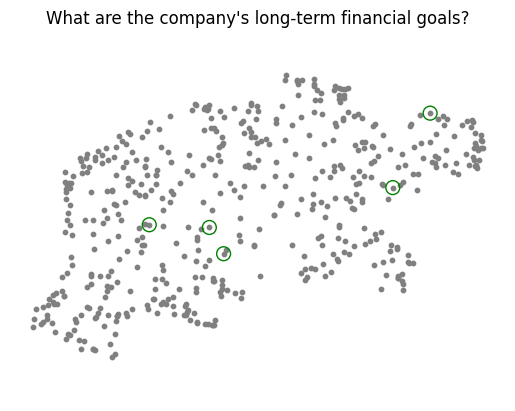

In [21]:
query = "What are the company's long-term financial goals?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Now, let's use an unrelated query and we'll observe how the results are more scattered around. Notice that the algorithm always returns close neighbors even if they are far appart. This is an indication that is returning results that are not necesseraly related to the query.

we continue to make significant research and development investments in areas of strategic focus as we seek to develop new, innovative offerings and improve our existing offerings across our businesses. we also expect to continue to invest in our technical infrastructure, including servers, network equipment, and data centers, to support the growth of our business and our long - term initiatives, in particular in support of ai. in addition acquisitions and strategic investments contribute to the breadth and depth of our offerings, expand our expertise in engineering and other functional areas, and build strong partnerships around strategic initiatives. for example, in september 2022 we closed the acquisition of mandiant to help expand our offerings in dynamic cyber defense and response. zwe face continuing changes in regulatory conditions, laws, and public policies, which could affect our business practices and financial results.

$ 5. 2 billion, and $ 7. 1 billion as of december 31, 2

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
 40%|████      | 2/5 [00:00<00:00, 15.43it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_f

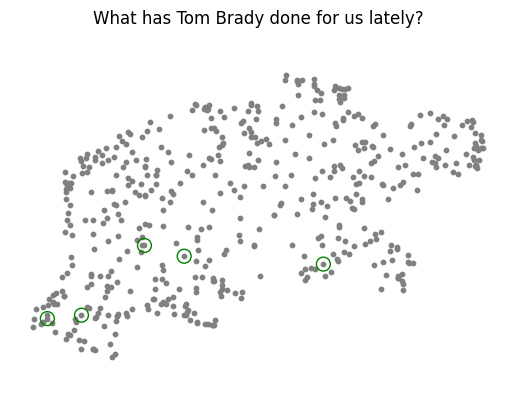

In [22]:
query = "What has Tom Brady done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

plot(title=query, projected_dataset_embeddings=projected_dataset_embeddings, projected_query_embedding=[], projected_retrieved_embeddings=projected_retrieved_embeddings)

Task 4. Query augmentation

One way of improving the results from queries is by getting more results of similar queries. This can be done either by creating similar queries or by sending an answer of what you might expect, so that you attach more context. In this task, you learn to expand your queries leveraging LLMs to do the heavy lifting.

Augment the query with a probable answer to give more context to the vector search.

In [23]:
def augment_query_generated(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Provide an example answer to the given question, that might be found in a document like an annual report.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query, model)

joint_query = f"{original_query} {hypothetical_answer}"
print(joint_query)

NotFound: 404 Publisher Model `projects/qwiklabs-gcp-01-5d9ec7df43cf/locations/us-central1/publishers/google/models/gemini-pro` was not found or your project does not have access to it. Please ensure you are using a valid model version. For more information, see: https://cloud.google.com/vertex-ai/generative-ai/docs/learn/model-versions

Perform the query with the new augmented query.

In [24]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

NameError: name 'joint_query' is not defined

Search for embeddings for the augmented query.

In [25]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(doc)
    print('')

NameError: name 'joint_query' is not defined

Get the embeddings for the queries and results and then map them to a 2-dimensional space.

In [26]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

NameError: name 'joint_query' is not defined

Map the results to get a visual understanding of the outcome. Notice that the seleted answers are closer to the augmented query datapoint.

NameError: name 'projected_original_query_embedding' is not defined

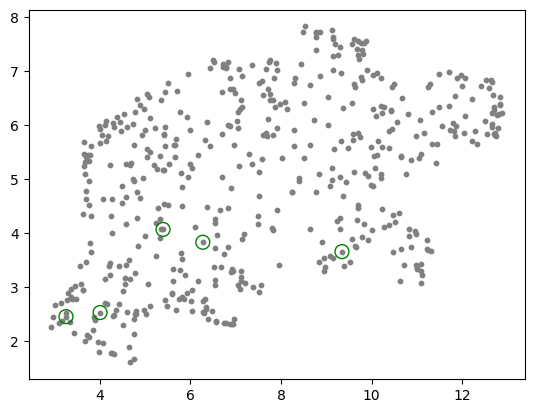

In [27]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Augment the query with a additional queries.

In [28]:
def augment_multiple_query(query, model):
    information = "\n\n".join(retrieved_documents)

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'Your users are asking questions about an annual report.\n'
    f'Suggest up to five additional related questions to help them find the information they need, for the provided question.\n'
    f'Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.\n'
    f'Make sure they are complete questions, and that they are related to the original question.\n'
    f'Output one question per line. Do not number the questions.\n'
    f'Question: {query}.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text

original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query, model)

joint_query = f"{original_query} \n{augmented_queries}"
print(joint_query)

NotFound: 404 Publisher Model `projects/qwiklabs-gcp-01-5d9ec7df43cf/locations/us-central1/publishers/google/models/gemini-pro` was not found or your project does not have access to it. Please ensure you are using a valid model version. For more information, see: https://cloud.google.com/vertex-ai/generative-ai/docs/learn/model-versions

Retrieve answers for all of these queries.

In [29]:
queries = [original_query] + augmented_queries.split('\n')
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(doc)
        print('')
    print('-'*100)

NameError: name 'augmented_queries' is not defined

Project the queries embeddings into a 2-dimensional space.

In [30]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)

NameError: name 'augmented_queries' is not defined

Project the answer embeddings into a 2-dimensional space.

In [31]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war

Plot the queries and answers to visualize their representation in space.

NameError: name 'project_augmented_queries' is not defined

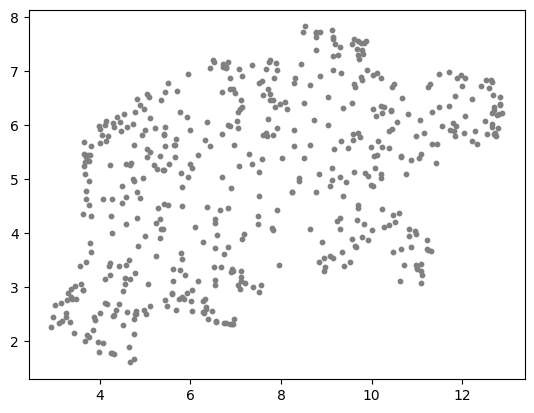

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Task 5. Re-ranking results

With the query expansion technique that we just discussed, we increased the cardinality of responses. We have a new problem now. The high amount of responses might be larges than the LLM's input token limit and, it will be more expensive to process such a high amount of tokens, since we are billed per token. One solution to this problem is to rerank the results and only send the most relevant ones. Now, instead of using the same cosine-similarity method as before, you could use a cross-encoder, a method that usually yields better results.

Import a cross encoder model.

In [34]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

Create unique pairs of query to document.

In [36]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

NameError: name 'unique_documents' is not defined

Create unique pairs of query to document.

In [35]:
scores = cross_encoder.predict(pairs)

print("Scores:")
for score in scores:
    print(score)

NameError: name 'pairs' is not defined

Reorder the pairs in terms of relevance.

In [37]:
print("New Ordering:")
ranked_docs=['']*len(scores)
i = 0
for position in np.argsort(scores)[::-1]:
    ranked_docs[position] = pairs[i][1]
    i+=1
    print(position)

New Ordering:


NameError: name 'scores' is not defined

Print the 5 most relevant documents.

In [38]:
ranked_docs[:5]

NameError: name 'ranked_docs' is not defined

Only send the most relevant answers to the LLM.

In [40]:
response = rag(query=original_query, retrieved_documents=ranked_docs[:5], model=model)
print(original_query)
print(response)

NameError: name 'ranked_docs' is not defined

Task 6. Embedding Adapters

Another improvement that we can make is instead of getting more answers and reranking, train the embedding model to work with our dataset based on user queries. This is a form a of fine tuning that you can do on your own.

Generate queries that might be asked to a financial statement. If you had real users, you would use those queries instead of making them up.

In [42]:
def generate_queries(model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'Suggest 10 to 15 short questions that are important to ask when analyzing an annual report.\n'
    f'Do not output any compound questions (questions with multiple sentences or conjunctions).\n'
    f'Output each question on a separate line divided by a newline.')
    
    responses = model.generate_content(prompt, stream=False)
    return responses.text.split('\n')

generated_queries = generate_queries(model)
for query in generated_queries:
    print(query)

NotFound: 404 Publisher Model `projects/qwiklabs-gcp-01-5d9ec7df43cf/locations/us-central1/publishers/google/models/gemini-pro` was not found or your project does not have access to it. Please ensure you are using a valid model version. For more information, see: https://cloud.google.com/vertex-ai/generative-ai/docs/learn/model-versions

Search answers for those queries

results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

Evaluate the results in 1 for relevant and -1 for irrelevant answers.

In [45]:
def evaluate_results(query, statement, model):

    prompt = (f'You are a helpful expert financial research assistant.\n'
    f'You help users analyze financial statements to better understand companies.\n'
    f'For the given query, evaluate whether the following satement is relevant.\n'
    f'Output only \'yes\' or \'no\'.\n'
    f'Question: {query}, Statement: {statement}.')
    
    responses = model.generate_content(prompt, stream=False)
    if responses.text == 'yes':
        return 1
    return -1

retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

NameError: name 'generated_queries' is not defined

Extract the documents and queries into their own lists.


In [46]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document, model))

len(adapter_labels)

NameError: name 'generated_queries' is not defined

Install PyTorch so that we can train the embedding model based on relevant answers.

In [47]:
!pip install torch

import torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Initialize PyTorch with the right data.

In [48]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

Set up the model with cosine similarity, so that embeddings with label 1 are similar and -1 are dissimilar.

In [49]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

Compute the mean squared error (MSE) loss to see how close are we to the expected output.

In [50]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

Initialize the adaptor matrix.

In [51]:
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

IndexError: index 0 is out of bounds for dimension 0 with size 0

Train the adaptor matrix using 100 steps by iteratively update a vector such that if I take that vector and multiply it by these inputs (query embeddings) then compare that result to this vector (this example's retrieved document vector), I get a score closer to (this example's -1 or 1 label).

In [52]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()       

100%|██████████| 100/100 [00:00<00:00, 8352.03it/s]
